### Exercise 15

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

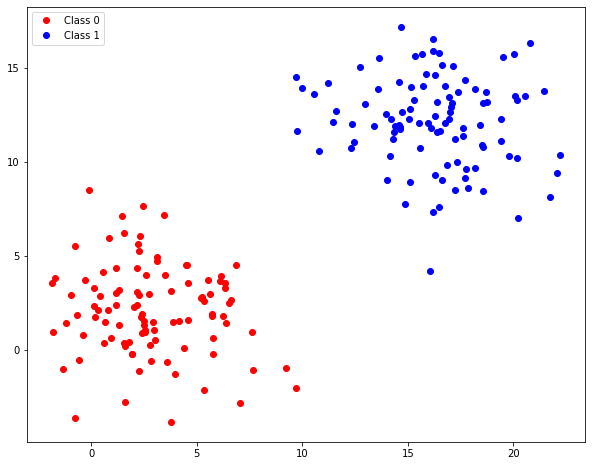

In [2]:
# Synthenic data
mu1 = np.array([3,2])
mu2 = np.array([16,12])
sigma = np.array([[6,0],[0,6]])

X1 = np.random.multivariate_normal(mu1,sigma,100)
X2 = np.random.multivariate_normal(mu2,sigma,100)

plt.figure(figsize=(10,8))
plt.plot(X1[:,0],X1[:,1],'ro',label='Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label='Class 1')
plt.legend()
plt.show()

#### Dual Lagrangian Optimization for Maximum Margin

- Traning data: $X \in R^{n}, y = \{-1,1\}$
$$
2D: \mathbf{X} = \begin{vmatrix}x_{1}^{1} & x_{2}^{1} \\x_{1}^{2} & x_{2}^{2}\\: & :\\x_{1}^{m} & x_{2}^{m}\end{vmatrix} , \mathbf{y} = \begin{vmatrix} -1\\-1\\:\\1\end{vmatrix}
$$

In [3]:
# Training data
X = np.concatenate((X1,X2),0)
y = np.concatenate((-np.ones((100,1)),np.ones((100,1))),0)
m = X.shape[0]
n = np.unique(y).shape[0]

**General Quadratic Programming**
$$x^{*} = arg \min_{x}\frac{1}{2}x^{T}Qx+c^{T}x+r $$ $$\text{Subject to : $Ax \leq b\\ Ex = d$}$$
- **cvxopt**.solvers.qp(P,q,G,h,A,b) find the **sol['x']**

**Dual Lagrangian**

Lagrangian Function:
$$ \mathcal L = \sum_{i=1}^{m}\alpha_{i} - \frac{1}{2} \sum_{i=1}^{m}\sum_{j=1}^{m}\alpha_{i}\alpha_{j}y^{(i)}y^{(j)}<x^{(i)},x^{(j)}>$$

**cvxopt** *requires that the problem be a minimization problem, so we need to multiplying Lagrangian function by -1*

Optimization Problem:
$$ \mathcal W(\alpha) = \min_{\alpha} \frac{1}{2} \sum_{i=1}^{m}\sum_{j=1}^{m}\alpha_{i}\alpha_{j}y^{(i)}y^{(j)}<x^{(i)},x^{(j)}> - \sum_{i=1}^{m}\alpha_{i} $$
$$\text{Such that: $-\alpha_{i} \le 0, i \in 1...m \\ \sum_{i=1}^{m}\alpha_{i}y^{(i)} = 0 $}$$

$$Q=y^{(i)}y^{(j)}<x^{(i)},x^{(j)}> ; c = \underbrace{\begin{vmatrix} -1\\-1\\:\\-1\end{vmatrix}}_{m \times 1} ; A = \underbrace{\begin{vmatrix}-1 & 0 & .. & 0 \\0 & -1 & .. & 0\\: & :& :\\-1 & 0 & .. & -1\end{vmatrix}}_{m \times m} ; b =\underbrace{\begin{vmatrix}0\\0 \\\\0\end{vmatrix}}_{m \times 1} ; E = \underbrace{\begin{vmatrix}y_{1} & y_{2} & .. & y_{m}\end{vmatrix}}_{1 \times m} ; d = 0$$

In [4]:
# Set Q,c,A,b,E,h
Q = (y@y.T)*(X@X.T)
c = - np.ones((m,1))
A = -np.eye(m)
b = np.zeros((m,1))
E = y.T
d = np.zeros((1,1))

In [5]:
# Define cvxopt_solvers_qp() function
def cvxopt_solvers_qp(Q,c,A=None,b=None,E=None,d=None):
    Q = .5*(Q+Q.T) # make Q is symmetric
    args = [cvxopt.matrix(Q),cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A),cvxopt.matrix(b)])
    if E is not None:
        args.extend([cvxopt.matrix(E),cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    return np.array(sol['x']).reshape(Q.shape[1])
opt_params = cvxopt_solvers_qp(Q,c,A,b,E,d)

     pcost       dcost       gap    pres   dres
 0: -1.4782e+01 -2.5234e+01  6e+02  2e+01  2e+00
 1: -1.0999e+01 -1.9833e+00  5e+01  2e+00  2e-01
 2: -2.9379e-01 -6.2768e-02  1e+00  5e-02  3e-03
 3: -1.8895e-02 -5.6660e-02  4e-02  7e-17  1e-14
 4: -3.6188e-02 -4.3538e-02  7e-03  2e-17  3e-15
 5: -4.2828e-02 -4.3208e-02  4e-04  8e-18  2e-15
 6: -4.3166e-02 -4.3170e-02  4e-06  2e-17  2e-15
 7: -4.3170e-02 -4.3170e-02  4e-08  9e-18  2e-15
Optimal solution found.


In [6]:
opt_params.shape

(200,)

In [7]:
print('Alphas that are not zero:', opt_params[opt_params > 1e-5])
print('Corresponding labels:\n',  y[opt_params > 1e-5])

Alphas that are not zero: [0.04316958 0.0159463  0.02722329]
Corresponding labels:
 [[-1.]
 [ 1.]
 [ 1.]]


**Find w,b**:

$\mathcal S \small \text{ is the set of indexes of the support vectors: } \mathcal S = \{ i \in 1..m | \alpha_{i} > 0 \}; N_{\mathcal S} = len(\mathcal S)$

$$b =\frac{1}{N_{\mathcal S}}\sum_{i \in \mathcal S} \left(y^{(i)} - \sum_{j \in \mathcal S}\alpha_{j}y^{(j)} \left<x^{(i)},x^{(j)}\right> \right)$$

$$w = \sum_{i=1}^{m}\alpha_{i}y^{(i)}x^{(i)}$$

In [8]:
# Define the function to find b,w
def find_b_w(X,y,alpha):
    S = np.where(alpha > 1e-5)[0] # numpy array
    X_s = X[S,:]
    y_s = y[S]
    alpha_s = alpha[S].reshape(-1,1)
    b = (y_s -((alpha_s*y_s).T*(X_s@X_s.T)).sum(axis=1, keepdims=True)).mean()
    w = ((alpha_s*y_s).T@X_s)
    print('Optimal Solution:',b,w)
    return b, w
b, w = find_b_w(X,y,opt_params)

Optimal Solution: -3.3915268694065976 [[0.22460549 0.18945057]]


**Make the prediction**
$$\mathcal h_{w,b}(x) = 
\begin{cases}
+ 1 \quad \text{$w^{T}x + b \ge 0$} \\ 
-1 \quad \text{otherwise}
\end{cases} \\
\text{Note that: $ w^{T}x + b = \sum_{i=1}^{m}\alpha_{i}y^{(i)}\left< x^{i},x \right> \\ \sum_{i=1}^{m}\alpha_{i}y^{(i)}\left< x^{(i)},x \right> = \left(\sum_{i}^{m}\alpha_{i}y^{(i)}x^{(i)} \right)^{T}x$}
$$

In [9]:
w.shape,X.shape,w[0,0]

((1, 2), (200, 2), 0.22460548619958165)

In [10]:
# Accuracy
y_pred = np.where(w@X.T+b >=0,+1,1)
accuracy = (y_pred == y).sum()/y.shape[0]
print('Accuracy:', accuracy)

Accuracy: 100.0


**Plot result**:
- Center line: $W^{T}\mathbf{x}+b = 0$
- Margin : $W^{T}\mathbf{x}+b = 1$
- Margin : $W^{T}\mathbf{x}+b = -1$

**n = 2**:

- Center line : $w_{1}x_{1}+w_{2}x_{2} + b = 0 \rightarrow x_{2} = \frac{-w_{1}x_{1}-b}{w_{2}}$
- Margin: $w_{1}x_{1}+w_{2}x_{2} + b = 1 \rightarrow x_{2} = \frac{-w_{1}x_{1}-b+1}{w_{2}}$
- Margin : $w_{1}x_{1}+w_{2}x_{2} + b = -1 \rightarrow x_{2} = \frac{-w_{1}x_{1}-b-1}{w_{2}}$

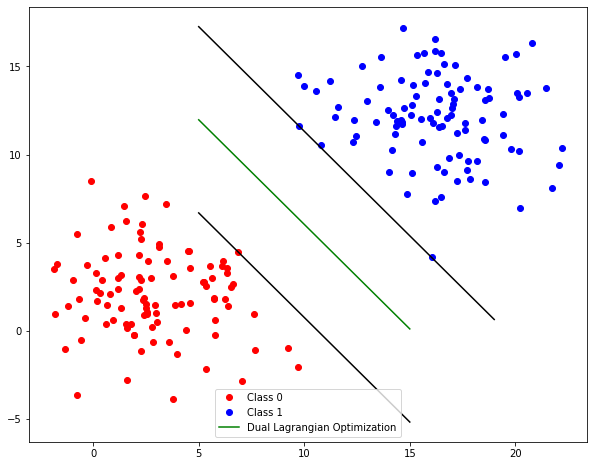

In [16]:
plt.figure(figsize=(10,8))
plt.plot(X1[:,0],X1[:,1],'ro',label='Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label='Class 1')

# Center line
x11 = 5
x12 = 15
x21 = (-w[0,0]*x11-b)/w[0,1]
x22 = (-w[0,0]*x12-b)/w[0,1]
plt.plot((x11,x12),(x21,x22),'g-',label='Dual Lagrangian Optimization')

# Red margin
x11 = 5
x12 = 15
x21 = (-w[0,0]*x11-b-1)/w[0,1]
x22 = (-w[0,0]*x12-b-1)/w[0,1]
plt.plot((x11,x12),(x21,x22),'k-')

# Blue margin
x11 = 5
x12 = 19
x21 = (-w[0,0]*x11-b+1)/w[0,1]
x22 = (-w[0,0]*x12-b+1)/w[0,1]
plt.plot((x11,x12),(x21,x22),'k-')

plt.legend()
plt.show()